In [1]:
! pip install markov_clustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import networkx as nx
import markov_clustering as mc
import pickle
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
from scipy.sparse import csr_matrix

#Кластеризованные графы

###Данные из предыдущей работы

In [53]:
with open('/content/drive/MyDrive/6/СС/1/another_users1.pickle', 'rb') as handle:
    users1 = pickle.load(handle)

In [54]:
with open('/content/drive/MyDrive/6/СС/1/another_users2.pickle', 'rb') as handle:
    users2 = pickle.load(handle)

In [55]:
with open('/content/drive/MyDrive/6/СС/1/another_friends1.pickle', 'rb') as handle:
    friends1 = pickle.load(handle)

In [56]:
with open('/content/drive/MyDrive/6/СС/1/another_friends2.pickle', 'rb') as handle:
    friends2 = pickle.load(handle)

In [57]:
edges1 = []
for member in users1:
  if member in friends1.keys():
    member_friends_list = friends1[member]
    if len(member_friends_list) > 0:
        for friend in member_friends_list:
            if ((friend, member) not in edges1) and (friend in users1):
                edges1.append((member, friend))

In [58]:
graph1 = nx.Graph()
graph1.add_edges_from(edges1)

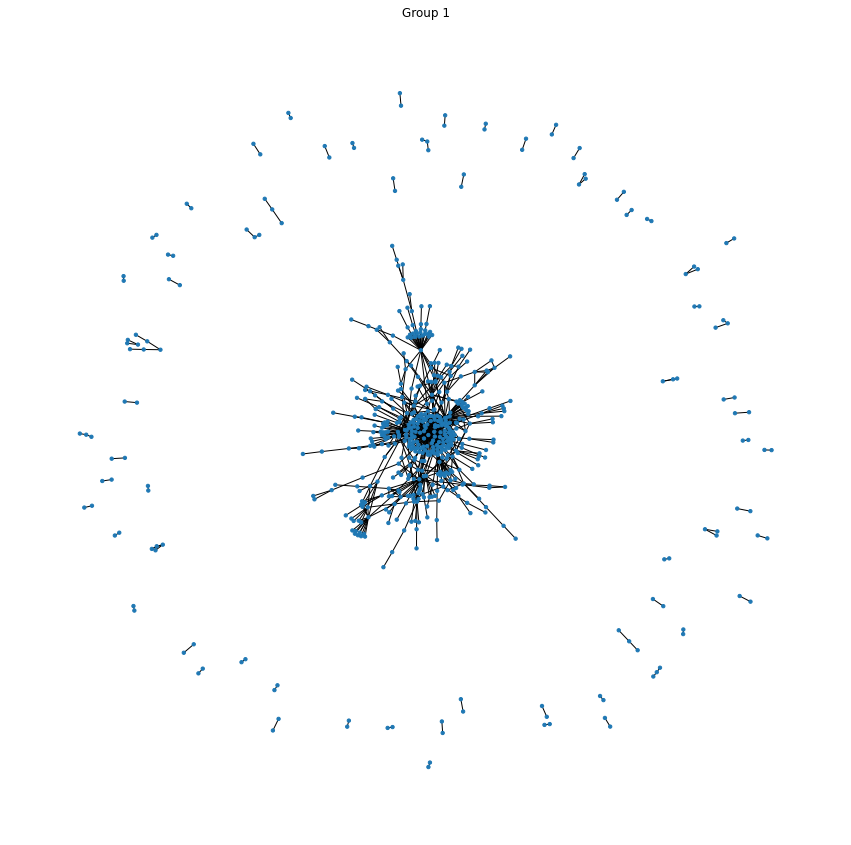

In [59]:
fig, ax = plt.subplots(figsize=(15,15))
nx.draw(graph1, with_labels=False,
        node_size=[11 for _ in range(len(graph1.nodes))])
plt.title('Group 1');

In [60]:
edges2 = []
for member in users2:
  if member in friends2.keys():
    member_friends_list = friends2[member]
    if len(member_friends_list) > 0:
        for friend in member_friends_list:
            if ((friend, member) not in edges2) and (friend in users2):
                edges2.append((member, friend))

In [61]:
graph2 = nx.Graph()
graph2.add_edges_from(edges2)

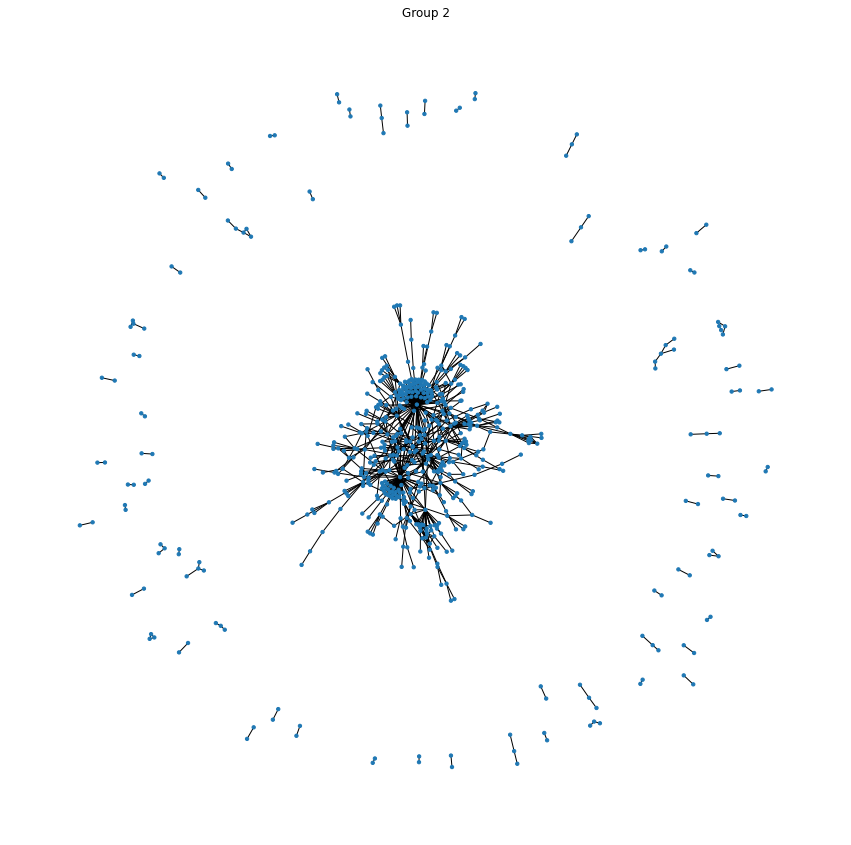

In [62]:
fig, ax = plt.subplots(figsize=(15,15))
nx.draw(graph2, with_labels=False,
        node_size=[11 for _ in range(len(graph2.nodes))])#, pos=pos_formula)
plt.title('Group 2');

###Графы 2 сообществ

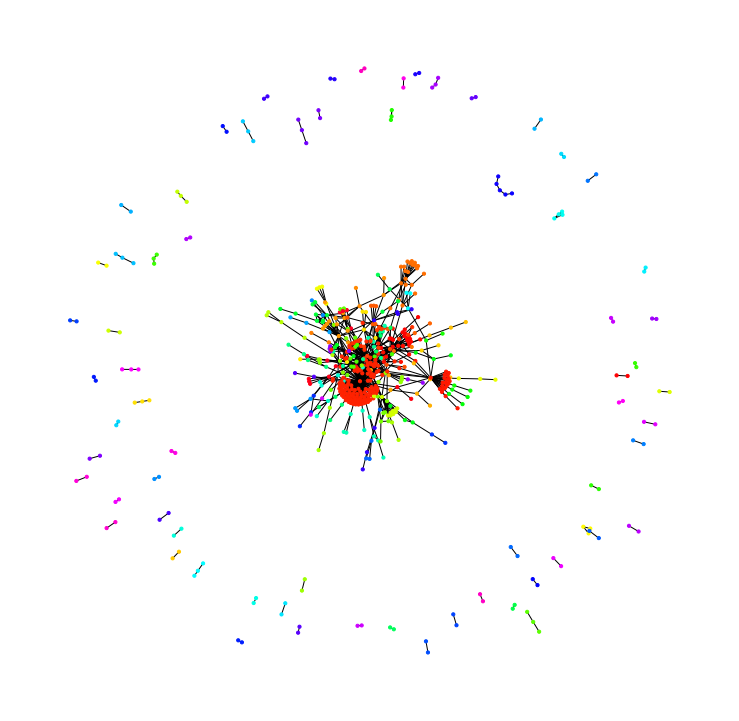

In [94]:
matrix1 = nx.to_scipy_sparse_matrix(graph1)
result1 = mc.run_mcl(matrix1)
clusters1 = mc.get_clusters(result1)
fig, ax = plt.subplots(figsize=(13,13))
mc.draw_graph(matrix1, clusters1, node_size=10, with_labels=False, cmap='gist_rainbow')

In [95]:
print('Количество кластеров 1 группы: {}'.format(len(clusters1)))

Количество кластеров 1 группы: 147


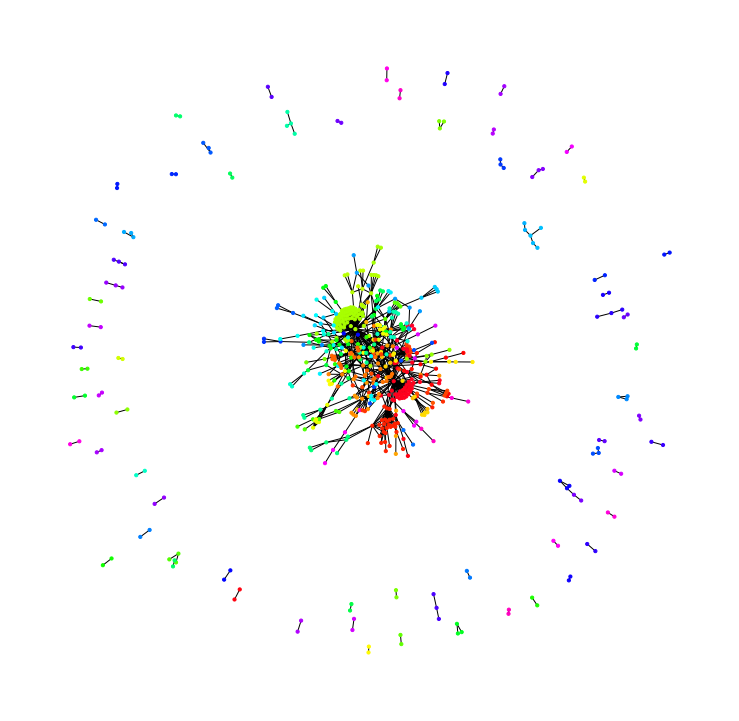

In [65]:
matrix2 = nx.to_scipy_sparse_matrix(graph2)
result2 = mc.run_mcl(matrix2)
clusters2 = mc.get_clusters(result2)
fig, ax = plt.subplots(figsize=(13,13))
mc.draw_graph(matrix2, clusters2, node_size=10, with_labels=False, cmap='gist_rainbow')

In [66]:
print('Количество кластеров 2 группы: {}'.format(len(clusters2)))

Количество кластеров 2 группы: 174


###Авторитетные пользователи

In [67]:
between_cent1 = nx.betweenness_centrality(graph1)

In [68]:
toplist1 = sorted(between_cent1, key=between_cent1.get, reverse=True)[:20]

In [69]:
between_cent2 = nx.betweenness_centrality(graph2)
toplist2 = sorted(between_cent2, key=between_cent2.get, reverse=True)[:20]

In [70]:
def draw_gr(graph, important_nodes, title=''):
  color_map = []
  node_sizes = []
  for node in graph:
    if node in important_nodes:
        color_map.append('red')
        node_sizes.append(20)
    else:
        color_map.append('grey')
        node_sizes.append(10)
  fig, ax = plt.subplots(figsize=(15,15))
  nx.draw(graph, node_color=color_map, with_labels=False, node_size=node_sizes)
  plt.title(title);

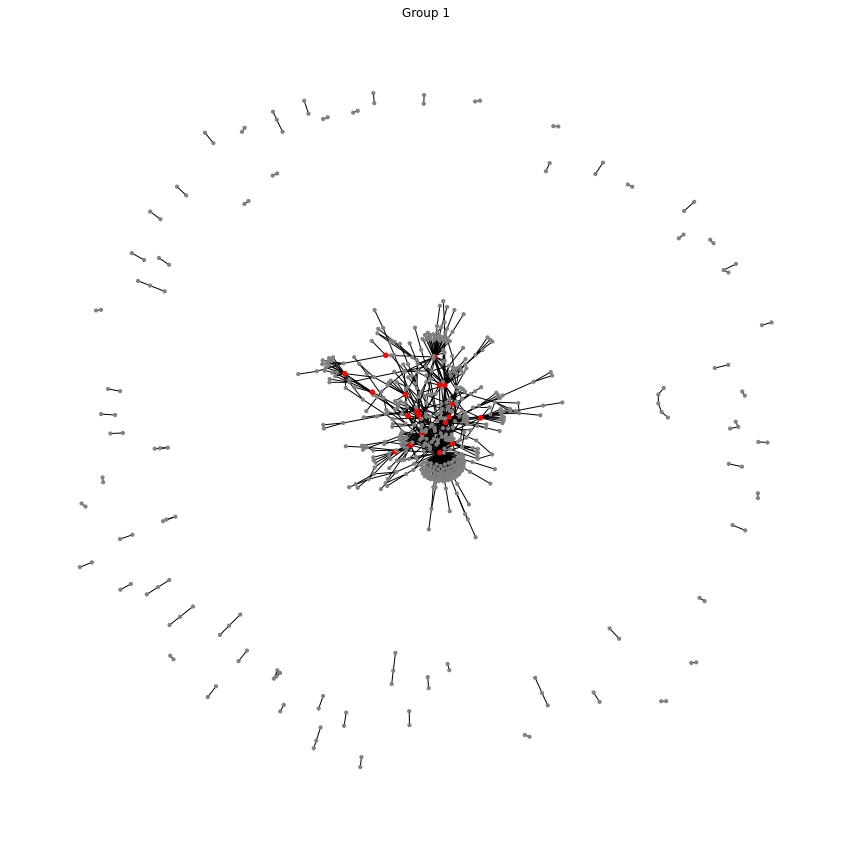

In [71]:
draw_gr(graph1,toplist1,'Group 1')

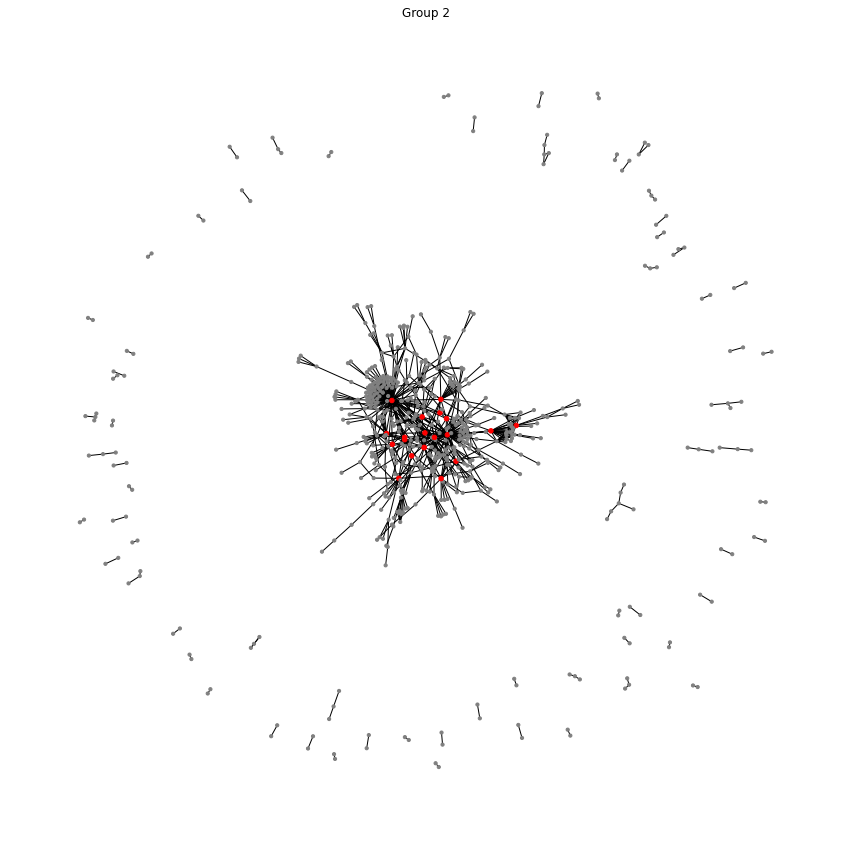

In [72]:
draw_gr(graph2,toplist2,'Group 2')

###Плотность социального графа

In [73]:
print("Nodes: ",len(graph1.nodes))
print("Edges: ",len(graph1.edges))

Nodes:  600
Edges:  737


In [74]:
e1 = len(graph1.edges)
v1 = len(graph1.nodes)

Максимальное число рёбер:

In [75]:
v1*(v1-1)/2

179700.0

Плотность:

In [76]:
2*e1/(v1*(v1-1))

0.004101279910962716

In [77]:
e2 = len(graph2.edges)
v2 = len(graph2.nodes)
v2*(v2-1)/2

203841.0

In [78]:
2*e2/(v2*(v2-1))

0.0038216060557002764

###Связность графа

In [79]:
nx.is_connected(graph1)

False

In [80]:
nx.number_connected_components(graph1)

68

In [81]:
nx.is_connected(graph2)

False

In [82]:
nx.number_connected_components(graph2)

70

###Степени узлов

In [83]:
adj_matr1 = matrix1.toarray()
k1 = [sum(adj_matr1[i]) for i in range(adj_matr1.shape[0])]
print('Min:', min(k1))
print('Max:', max(k1))
print('Avg:', np.round(np.average(k1)))

Min: 1
Max: 148
Avg: 2.0


In [84]:
adj_matr2 = matrix2.toarray()
k2 = [sum(adj_matr2[i]) for i in range(adj_matr2.shape[0])]
print('Min:', min(k2))
print('Max:', max(k2))
print('Avg:', np.round(np.average(k2)))

Min: 1
Max: 110
Avg: 2.0


###Модулярность

In [85]:
def modularity(matrix, clusters):
  k = [sum(matrix[i]) for i in range(matrix.shape[0])]
  s = np.zeros((matrix.shape[0], len(clusters)))
  b = np.zeros(matrix.shape)

  for i, cluster in enumerate(clusters):
    for j in cluster:
      s[j][i] = 1
  
  _, counts = np.unique(matrix, return_counts=True)
  m = min(counts)/2

  for i in range(len(k)):
    b[i] = [matrix[i][j]-(k[i]*k[j])/(2*m) for j in range(len(k))]
  
  trace = np.trace(np.transpose(s) @ b @ s)
  q = trace/(2*m)

  return q

In [86]:
modularity(adj_matr1, clusters1)

0.6348898777360269

In [87]:
modularity(adj_matr2, clusters2)

0.6595351995003635

In [91]:
def chose_best(matrix):
  best_infl = 0
  best_modularity = 0
  adj_matr = matrix.toarray()

  for inflation in [i / 10 for i in range(15, 26)]:
    result = mc.run_mcl(matrix, inflation=inflation)
    clusters = mc.get_clusters(result)
    q = modularity(adj_matr, clusters)
    if q > best_modularity:
      best_modularity = q
      best_infl = inflation
      best_clusters = clusters
  
  print('Best inflation: ', best_infl)
  print('Best modularity: ', best_modularity)
  print('Best number of clusters: ', len(best_clusters))

  fig, ax = plt.subplots(figsize=(13,13))
  mc.draw_graph(matrix, best_clusters, node_size=10, with_labels=False, cmap='gist_rainbow')

  pass

Best inflation:  1.7
Best modularity:  0.6661895284892915
Best number of clusters:  115


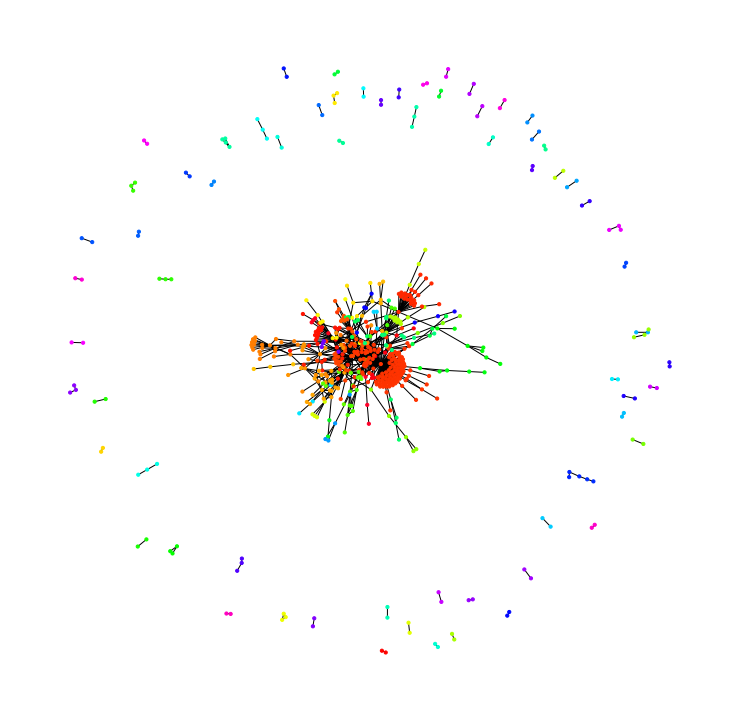

In [92]:
chose_best(matrix1)

Best inflation:  1.6
Best modularity:  0.7067427876494835
Best number of clusters:  119


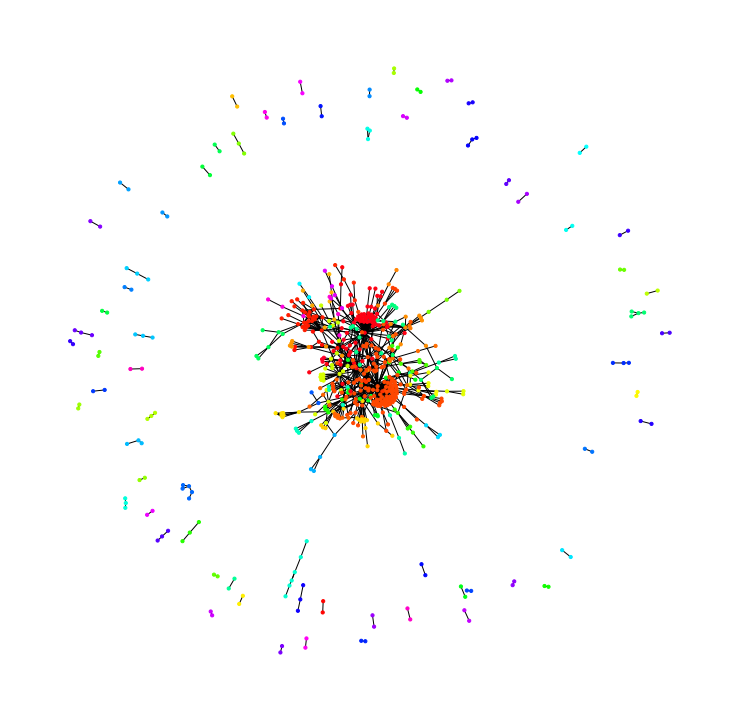

In [93]:
chose_best(matrix2)